# ***CODE FOR THE HYBRID MODEL***

### ***Loading and configuration***

One of the models used in our research was the Hybrid model (`vit_base_r50_s16_224`), which we took from the timm library. This model comes pre-trained on the ImageNet-21k dataset, providing a robust starting point for our fine-tuning and evaluation tasks.

### ***Libraries and dependencies***

In [ ]:
#! pip install transformers
#! pip install torch
#! pip install torchvision
#! pip install torch.utils
#! pip install datasets
#! pip install optuna
#! pip install fvcore

import fvcore
from fvcore.nn import FlopCountAnalysis
import torch
import timm
from transformers import ViTForImageClassification, ViTConfig, get_cosine_schedule_with_warmup
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import optuna
from torch.optim import SGD
import pandas as pd
from torchvision.transforms import ToPILImage, Normalize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import defaultdict


  Preparing metadata (setup.py) ... done
  Created wheel for torch.utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6187 sha256=9ebed4dc741b35d91006db0601dd9455489518941a1774f1c6dfed6dfead0866
  Stored in directory: /root/.cache/pip/wheels/76/08/f0/378d1fe4aac5aa1e21483918d70b7e3428c4faaac0abda4e15
Successfully built torch.utils
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ***Customizing the Models for Fine-Tuning***

After loading the model, we adjusted the classification head an freezed all the layers except for the head.

In [ ]:
num_classes = 20

# Let's load the pre-trained R50+ViT-B/16 model
model = timm.create_model('vit_base_r50_s16_224', pretrained=True)

# Check the type of model.head
print(type(model.head)) # to confirm if its indeed Identity
# If model.head is an Identity layer, replace it with a Linear layer:
if isinstance(model.head, torch.nn.Identity):
    in_features = model.num_features
    model.head = torch.nn.Linear(in_features, num_classes)
else:
    # If not Identity, then replace classification head as you originally intended
    model.head = torch.nn.Linear(model.head.in_features, num_classes)

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Let's have a look at the model's structure
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

<class 'torch.nn.modules.linear.Identity'>
VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (drop): Identity()
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_siz

In [ ]:
# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the classification head
for param in model.head.parameters():
    param.requires_grad = True

### ***Preparing the Dataset***

After customizing the models, we also preprocessed the images to ensure compatibility. Each image was resized to (224*224) pixels to standardize the input dimensions, and the pixel values were normalized using a mean of \([0.485, 0.456, 0.406]\) and a standard deviation of \([0.229, 0.224, 0.225]\), standerd values for ImageNet pre-trained models.

In [ ]:
# Preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/Dataset/Subsample_20_classes_spliited/subset_only_20_train", transform=transform)
val_dataset = datasets.ImageFolder("/content/drive/MyDrive/Dataset/Subsample_20_classes_spliited/subset_only_20_val", transform=transform)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/Dataset/Subsample_20_classes_spliited/subset_only_20_test", transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


#### ***FLOPs***

Then we computed the FLOPs (Floating Point Operations) of the models to evaluate their computational complexity and efficiency. This metric provides insight into the amount of computational effort required for a forward pass, helping us compare the performance and resource demands of different models.<br> It will be used to make an accuracy vs FLOPs graph later.

In [ ]:
for images, _ in test_loader:
    input_tensor = images.to(device)
    break

# FLOPs computation
flops = FlopCountAnalysis(model, input_tensor)
print(f"Total FLOPs for one forward pass: {flops.total()} FLOPs")

dataset_size = len(train_dataset)
num_epochs = 10
batch_size = 32

total_flops = (flops.total() * dataset_size * num_epochs) / batch_size
print(f"Total FLOPs for fine-tuning: {total_flops}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=893c81b1b193a285468345c98f5425f0dbc713c83e8dbe73b9e5e67f30eb33f2
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=3f6a5d26ec7f32363e02d64272c14df153627d592e8b4965cecbac5b4d037fff
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


blocks.0.attn.attn_drop, blocks.1.attn.attn_drop, blocks.10.attn.attn_drop, blocks.11.attn.attn_drop, blocks.2.attn.attn_drop, blocks.3.attn.attn_drop, blocks.4.attn.attn_drop, blocks.5.attn.attn_drop, blocks.6.attn.attn_drop, blocks.7.attn.attn_drop, blocks.8.attn.attn_drop, blocks.9.attn.attn_drop, patch_embed.backbone.head.global_pool


Total FLOPs for one forward pass: 668691919616 FLOPs
Total FLOPs for fine-tuning: 501518939712000.0


### ***FINE-TUNING***

### ***Fine-tuning configurations***

We started with the hyperparameter values for fine-tuning that are detailed in the appendix of the [paper](https://arxiv.org/abs/2010.11929), Section B.1.1:

- ***Learning Rate:***  
  The learning rate is managed using a **cosine learning rate decay**, implemented in the `create_learning_rate_scheduler()` function found in `utils.py`. For our experiment, we use a base learning rate of **0.03** with cosine decay, as described in the paper.  

- ***Batch:***  
  The batch size is defined in the `common.py` file under `config.batch`. Initially, we set a batch size of **218** due to computational power and GPU memory constraints. The default batch size in the repository (`512`) can be used if memory allows.  

- ***Steps/Epochs:***  
  We fine-tune the model for **10,000 steps** or equivalent epochs depending on the batch size. This is specified in `common.py` under `config.total_steps`.  

- ***Regularization:***  
  No weight decay is applied, as specified in the paper.  

- ***Optimizer:***  
  The optimizer is defined in the `train.py` script and utilizes **SGD with momentum** (momentum = **0.9**), matching the paper's recommendations. This is configured using the `optax` library, specifically in the `tx` optimizer setup.

Though, these values were optimized for datasets like ImageNet, and given the differences between the datasets used in the research and Places365 adjustments were made to adapt to the specific characteristics and constraints of our dataset, such as size and computational resources.<br> An automatic hyperparameter tuning was performed with the `optuna library` to asses the best learning rate of the cosine learning rate decay and the momentum of the SGD optimizer.

Now we can go with the ***automatic hyperparameter tuning***:

In [ ]:
# Hyperparameters
num_epochs = 5
max_grad_norm = 1.0
loss_fn = torch.nn.CrossEntropyLoss()

#Objective function
def objective(trial):

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    momentum = trial.suggest_uniform('momentum', 0.7, 0.99)

    # Optimizer
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= 0)

    # Scheduler
    num_training_steps = len(train_loader) * num_epochs
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=100,
        num_training_steps=num_training_steps
    )

    model.to(device)

    # Training and validation
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total

    return validation_accuracy


# Optuna study to maximize validation accuracy
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial

print(f"  Validation Accuracy: {trial.value}")
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-12-18 15:52:52,830] A new study created in memory with name: no-name-f50bafc2-8f86-47c5-94a8-7d8e38379c1e
<ipython-input-10-6f3d415c94d3>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate range
<ipython-input-10-6f3d415c94d3>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)  # Momentum range
[I 2024-12-18 16:19:23,456] Trial 0 finished with value: 76.75 and parameters: {'lr': 0.0016889894071171142, 'momentum': 0.806585395444392}. Best is trial 0 with value: 76.75.
[I 2024-12-18 16:23:32,979] Trial 1 finished with value: 79.125 and parameters: {'lr': 6.47309451

Best trial:
  Validation Accuracy: 86.125
  Best Hyperparameters:
    lr: 0.006127295601238989
    momentum: 0.9815597169137187


To see all the hyperpameter combinations for the fine-tuning:

In [ ]:
print("All trials:")

trial_results = []
for trial in study.trials:
    trial_results.append({
        "Trial Number": trial.number,
        "Learning Rate (lr)": trial.params.get("lr"),
        "Momentum": trial.params.get("momentum"),
        "Weight Decay": trial.params.get("weight_decay"),
        "Validation Accuracy": trial.value
    })

results_df = pd.DataFrame(trial_results)

print(results_df)

results_df.to_csv("hyperparameter_results_R50_vit16.csv", index=False)
print("Results saved to hyperparameter_results_R50_vit16.csv")


All trials:
   Trial Number  Learning Rate (lr)  Momentum Weight Decay  \
0             0            0.001689  0.806585         None   
1             1            0.000065  0.922899         None   
2             2            0.000032  0.799547         None   
3             3            0.006127  0.981560         None   
4             4            0.000206  0.822080         None   

   Validation Accuracy  
0               76.750  
1               79.125  
2               79.500  
3               86.125  
4               86.000  
Results saved to hyperparameter_results_R50_vit16.csv


### ***Training***
Then, after finding the best hyperparameter values we can traing the models:

In [ ]:
num_epochs = 10
max_grad_norm = 1.0
lr = 0.006
momentum = 0.98

#Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0)
loss_fn = torch.nn.CrossEntropyLoss()

#Cosine scheduler
num_training_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_accuracies = [] -

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        batch_accuracy = 100 * correct / total
        batch_accuracies.append(batch_accuracy)

    avg_train_loss = total_loss / len(train_loader)
    std_train_accuracy = np.std(batch_accuracies)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Std Dev Accuracy: {std_train_accuracy:.4f}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

Epoch 1/10, Train Loss: 2.0769, Std Dev Accuracy: 33.8962
Validation Accuracy: 84.38%
Epoch 2/10, Train Loss: 0.3743, Std Dev Accuracy: 5.9803
Validation Accuracy: 86.12%
Epoch 3/10, Train Loss: 0.2017, Std Dev Accuracy: 4.2830
Validation Accuracy: 85.38%
Epoch 4/10, Train Loss: 0.0932, Std Dev Accuracy: 3.2275
Validation Accuracy: 84.50%
Epoch 5/10, Train Loss: 0.0454, Std Dev Accuracy: 1.6905
Validation Accuracy: 84.50%
Epoch 6/10, Train Loss: 0.0280, Std Dev Accuracy: 0.7022
Validation Accuracy: 85.00%
Epoch 7/10, Train Loss: 0.0220, Std Dev Accuracy: 0.0000
Validation Accuracy: 85.00%
Epoch 8/10, Train Loss: 0.0197, Std Dev Accuracy: 0.0000
Validation Accuracy: 85.00%
Epoch 9/10, Train Loss: 0.0187, Std Dev Accuracy: 0.0000
Validation Accuracy: 85.00%
Epoch 10/10, Train Loss: 0.0184, Std Dev Accuracy: 0.0000
Validation Accuracy: 85.00%


In [ ]:
#To save the model
save_path = "R50_ViT_B16_weights.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'num_epochs': num_epochs,
}, save_path)
print(f"Model saved to {save_path}")

Model saved to R50_ViT_B16_weights.pth


In [ ]:
#Let's reload the model

# Define the number of classes and device
num_classes = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize the model architecture
fine_tuned_model = timm.create_model('vit_base_r50_s16_224', pretrained=False)

# Replace the head with the same custom Linear layer
if isinstance(fine_tuned_model.head, torch.nn.Identity):
    in_features = fine_tuned_model.num_features
    fine_tuned_model.head = torch.nn.Linear(in_features, num_classes)
else:
    fine_tuned_model.head = torch.nn.Linear(fine_tuned_model.head.in_features, num_classes)

# Load the trained model state
checkpoint = torch.load("R50_ViT_B16_weights.pth")
fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

fine_tuned_model.to(device)

print("Trained model loaded successfully as fine_tuned_model for testing.")


<ipython-input-24-ff03f48d2045>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("R50_ViT_B16_weights.pth")  # Replace with your saved model path


Trained model loaded successfully as fine_tuned_model for testing.


### ***Testing***
And after training the model we test it:

In [ ]:
model.eval()
correct = 0
total = 0
batch_accuracies = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        batch_correct = (predicted == labels).sum().item()
        batch_total = labels.size(0)

        batch_accuracy = 100 * batch_correct / batch_total
        batch_accuracies.append(batch_accuracy)

        correct += batch_correct
        total += batch_total

accuracy = 100 * correct / total

std_dev = np.std(batch_accuracies)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Standard Deviation of Batch Accuracies: {std_dev:.2f}%")

Test Accuracy: 86.00%
Standard Deviation of Batch Accuracies: 10.83%


### ***METRICS***

To evaluate the model’s performance in detail, we computed class-wise accuracy and analyzed the confusion matrix. ***Class-wise accuracy*** measures the percentage of correctly predicted samples for each individual class, providing insights into how well the model performs across different categories, that helps to identify the classes where the model excels or struggles.

Additionally, the ***confusion matrix*** offers a comprehensive view of the model’s predictions, showing the distribution of true labels versus predicted labels.



***Class-wise accuracy***

In [ ]:
model.eval()

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

# To evaluate on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            total_per_class[label.item()] += 1
            if label.item() == prediction.item():
                correct_per_class[label.item()] += 1

class_names = test_loader.dataset.classes
accuracies = [100 * correct_per_class[i] / total_per_class[i] for i in range(len(class_names))]

print("Class-wise Accuracy:")
for class_idx, class_name in enumerate(class_names):
    print(f"{class_name}: {accuracies[class_idx]:.2f}%")

Class-wise Accuracy:
airport_terminal: 90.00%
amusement_park: 80.00%
aquarium: 97.50%
ballroom: 97.50%
barn: 85.00%
beach: 87.50%
bedroom: 100.00%
bridge: 80.00%
canyon: 67.50%
castle: 75.00%
church_outdoor: 70.00%
forest_path: 75.00%
highway: 80.00%
kitchen: 92.50%
library_indoor: 97.50%
mountain: 72.50%
restaurant: 90.00%
skyscraper: 90.00%
stadium_soccer: 97.50%
swimming_pool_outdoor: 95.00%


***Confusion Matrix***

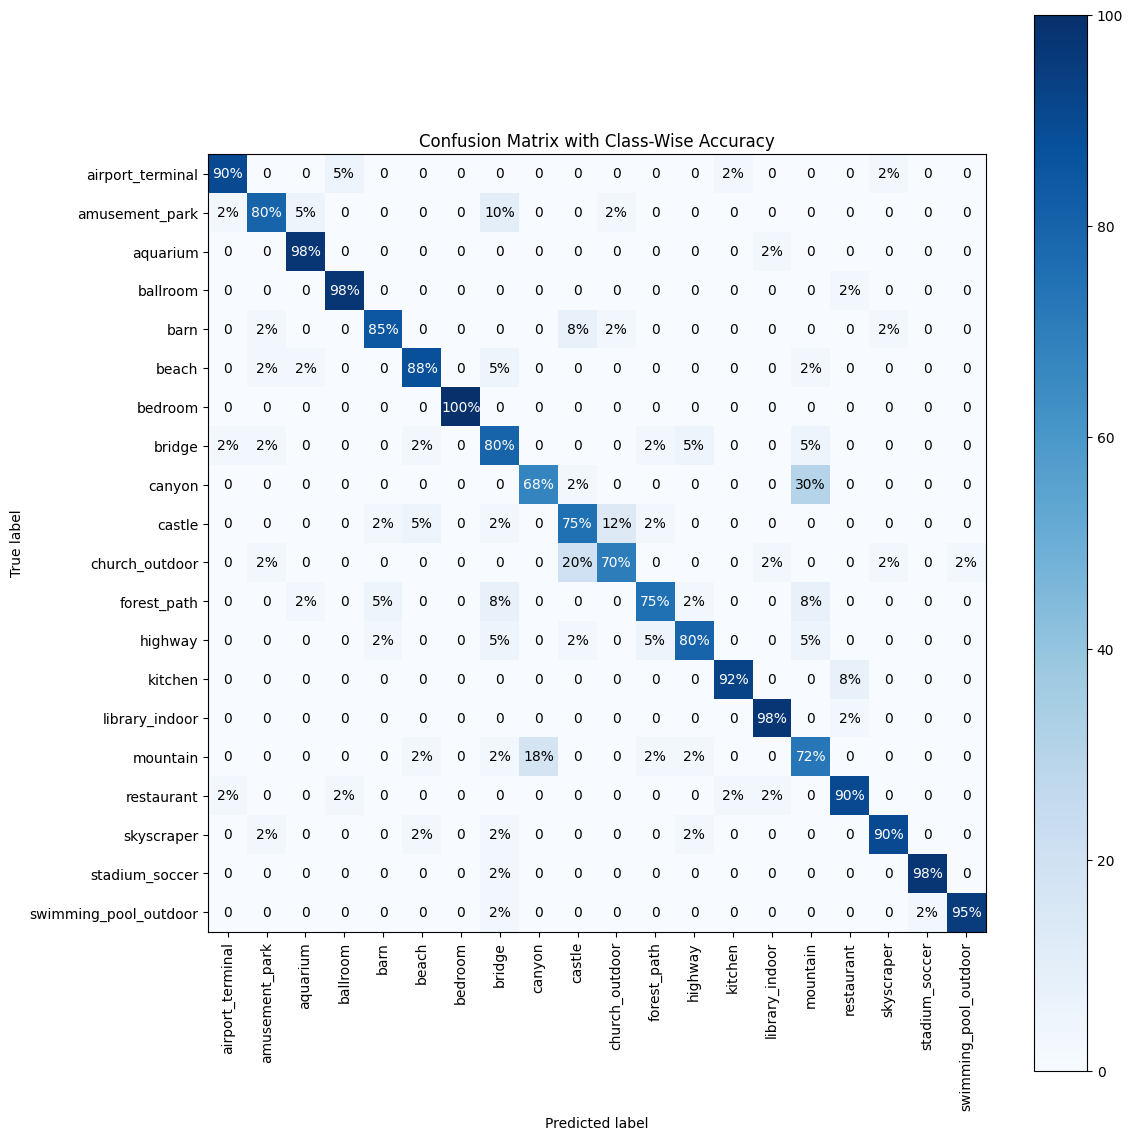

In [ ]:
fine_tuned_model.eval()

all_predictions = []
all_labels = []

# To evaluate on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = fine_tuned_model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_loader.dataset.classes

cm_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

annot = np.array([
    [f"{cm_percentage[i, j]:.0f}%" if cm[i, j] != 0 else "0" for j in range(len(class_names))]
    for i in range(len(class_names))
])

plt.figure(figsize=(12, 12))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Class-Wise Accuracy")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, annot[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#### ***Attention maps***

After evaluating the models using class-wise accuracy and the confusion matrix to quantify their performance, and after experimenting a bit with the attentions maps in the ViT_B_32 ipynb file, we further analyzed their behavior by generating attention maps, with a particular focus on misclassified images. These maps provide visual insights into the regions of the input that the model focused on while making predictions, allowing us to better understand potential sources of misclassification. By highlighting the most relevant areas of an image for each class, attention maps enhance interpretability and help identify whether the model's focus aligns with meaningful features or distracts towards irrelevant areas. This qualitative analysis offers a complementary perspective to the quantitative evaluation metrics, shedding light on the model’s decision-making process.

We focused on identifying and analyzing misclassified images, particularly for the class pairs 'church_outdoor' and 'castle' as well as 'canyon' and 'mountain,' since these were the most frequently misclassified categories by the model, as it can be seen from the metrics from the previous section.

So, first we implemented a method to identify and analyze misclassified images by mapping their predicted and true labels to class names:

In [ ]:
label_mapping = {
    0: "airport_terminal",
    1: "amusement_park",
    2: "aquarium",
    3: "ballroom",
    4: "barn",
    5: "beach",
    6: "bedroom",
    7: "bridge",
    8: "canyon",
    9: "castle",
    10: "church_outdoor",
    15: "mountain"
}

def get_misclassified_images(dataset, model, device, label_mapping):
    """
    Get the misclassified images and their indices from a dataset.

    Parameters:
        dataset: The dataset containing the images.
        model: The fine-tuned ViT model.
        device: The device (CPU/GPU) to run the model.
        label_mapping: A dictionary mapping label indices to class names.

    Returns:
        misclassified: A list of tuples containing (image, true_label, predicted_label, index).
    """
    misclassified = []

    model.eval()

    # Iterate through the dataset
    for idx, (image, label) in enumerate(dataset):

        input_tensor = image.unsqueeze(0).to(device)

        # Perform prediction
        with torch.no_grad():
            outputs = model(input_tensor)
            predicted_label = torch.argmax(outputs, dim=1).item()

        if label in label_mapping and predicted_label in label_mapping:
            true_label_name = label_mapping[label]
            pred_label_name = label_mapping[predicted_label]
        else:
            continue

        # Check for misclassification
        if label != predicted_label:
            misclassified.append((image, true_label_name, pred_label_name, idx))

    return misclassified

# Labels of interest
labels_to_find = [8, 15]

misclassified_images = get_misclassified_images(test_dataset, model, device, label_mapping)

filtered_misclassified = [
    (img, true_label, pred_label, idx)
    for img, true_label, pred_label, idx in misclassified_images
    if any(true_label == label_mapping[label] for label in labels_to_find)
]

print(f"Found {len(filtered_misclassified)} misclassified images for 'castle' and 'church_outdoor'.")

for img, true_label, pred_label, idx in filtered_misclassified:
    print(f"Index: {idx}, True Label: {true_label}, Predicted Label: {pred_label}")

    pil_image = ToPILImage()(img)
    pil_image.show()

Found 22 misclassified images for 'castle' and 'church_outdoor'.
Index: 321, True Label: canyon, Predicted Label: mountain
Index: 323, True Label: canyon, Predicted Label: mountain
Index: 326, True Label: canyon, Predicted Label: mountain
Index: 327, True Label: canyon, Predicted Label: mountain
Index: 334, True Label: canyon, Predicted Label: mountain
Index: 336, True Label: canyon, Predicted Label: castle
Index: 337, True Label: canyon, Predicted Label: mountain
Index: 338, True Label: canyon, Predicted Label: mountain
Index: 345, True Label: canyon, Predicted Label: mountain
Index: 346, True Label: canyon, Predicted Label: mountain
Index: 347, True Label: canyon, Predicted Label: mountain
Index: 349, True Label: canyon, Predicted Label: mountain
Index: 356, True Label: canyon, Predicted Label: mountain
Index: 608, True Label: mountain, Predicted Label: canyon
Index: 612, True Label: mountain, Predicted Label: canyon
Index: 615, True Label: mountain, Predicted Label: canyon
Index: 61

And then we printed the corresponding attention map to visualize the regions of the image that the model focused on during its prediction, highlighting the aggregated attention across multiple heads and layers for better interpretability:

In [ ]:
def get_attention_maps(module, input, output):
    """Hook function to extract attention maps."""
    global attention_maps
    attention_maps.append(output)

def visualize_aggregated_attention(dataset, idx, fine_tuned_model, device, layer_idx=5, head_range=(0, 11), patch_size=16):
    """
    Visualize the aggregated attention map across a range of heads for a specific layer in a hybrid ViT model.

    Parameters:
        dataset: The dataset containing the image (e.g., test_dataset).
        idx: Index of the image in the dataset.
        fine_tuned_model: The hybrid model (ResNet+ViT).
        device: The device (CPU/GPU) to run the model.
        layer_idx: The index of the transformer layer to visualize (default is 5).
        head_range: Tuple specifying the range of heads to aggregate (inclusive).
        patch_size: The patch size used by the ViT model (default is 16).

    Returns:
        None: Displays the original image and the aggregated attention map.
    """
    global attention_maps
    attention_maps = []

    # Load and preprocess the image
    image, _ = dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    attention_layer = fine_tuned_model.blocks[layer_idx].attn
    hook = attention_layer.register_forward_hook(get_attention_maps)

    # Perform a forward pass
    fine_tuned_model.eval()
    with torch.no_grad():
        _ = fine_tuned_model(input_tensor)

    hook.remove()

    if not attention_maps:
        raise RuntimeError("No attention maps were captured. Ensure the hook is attached to the correct layer.")

    # Extract the attention map for the specified layer
    attention = attention_maps[0]  # [batch_size, num_patches+1, hidden_dim]
    if attention.dim() == 3:
        attention = attention[0]  # Remove batch dimension
        attention = attention[1:]  # Exclude CLS token
        aggregated_attention = attention.mean(dim=1)

    else:
        raise ValueError("Unexpected attention map dimensions. Ensure the model outputs attention correctly.")

    num_patches = aggregated_attention.size(0)
    grid_size = int(num_patches ** 0.5)
a
    if grid_size * grid_size != num_patches:
        raise ValueError(
            f"Attention map size ({num_patches}) does not match a perfect square. "
            "Verify the input resolution and patch embedding behavior."
        )

    aggregated_attention = aggregated_attention.reshape(grid_size, grid_size)

    attention_map = torch.nn.functional.interpolate(
        aggregated_attention.unsqueeze(0).unsqueeze(0),
        size=(image.size(-2), image.size(-1)),
        mode="bilinear"
    )[0, 0].cpu().numpy()

    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    # Unnormalize the image for visualization
    unnormalize = Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
    )
    original_image = unnormalize(image).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

    # Visualize the original image and aggregated attention map
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_image)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(original_image, alpha=0.6)
    ax[1].imshow(attention_map, cmap="jet", alpha=0.4)
    ax[1].axis("off")
    ax[1].set_title(f"Aggregated Attention Map (Layer {layer_idx}, Heads {head_range[0]}-{head_range[1]})")

    plt.tight_layout()
    plt.show()

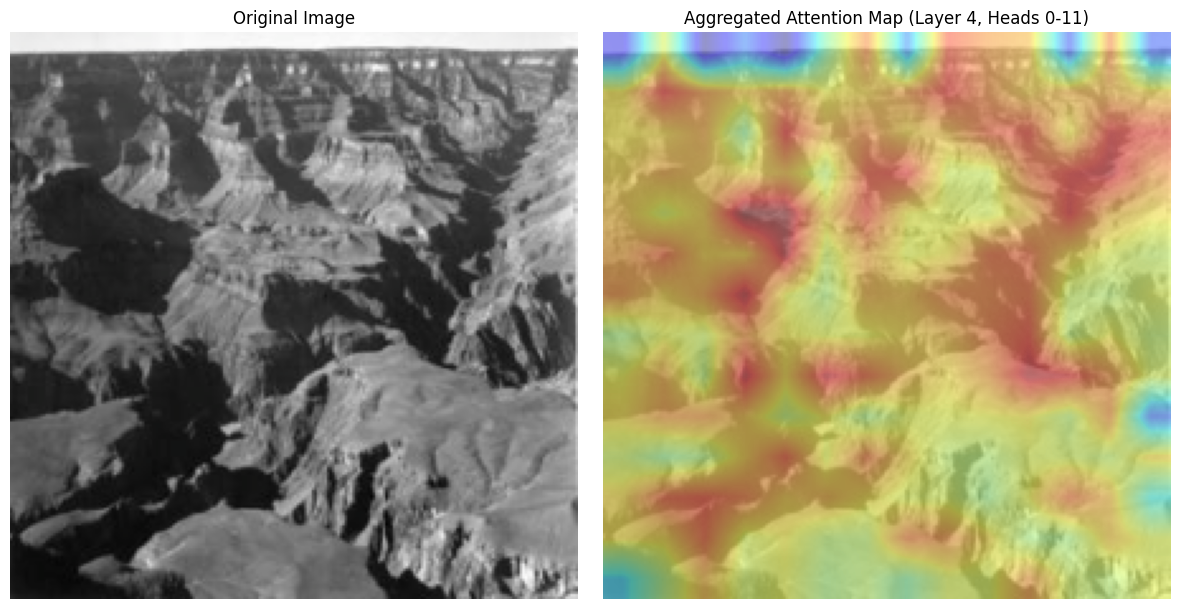

In [ ]:
# Visualize aggregated attention for a specific image and layer
idx = 359  # Image index
visualize_aggregated_attention(test_dataset, idx=idx, fine_tuned_model=model, device=device, layer_idx=4, head_range=(0, 11))